In [415]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
import math
from typing import List
pd.options.display.max_rows = 4000

In [416]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [417]:
data_features = pd.read_csv("data/features.csv")
data_features = plotting.extract_needed_cols(data_features, remove_cols=['feifeis_ylabels', 'liams_ylabels', 'distances'])
clustering_features = plotting.extract_numerical_features(data_features)


ylabel_name = 'marions_ylabels'
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
print(f'marions_labeled_data: \n{marions_labeled_data[:3]}')

marions_labeled_data: 
   max_depth  max_resistance  num_peaks  largest_force_drop  curve_shape  \
0  -0.406696        0.739042  -0.696539           -0.667883     0.729832   
2   0.562019       -0.214852  -0.696539            0.019005    -0.863595   
8  -0.706037        0.819788  -0.696539           -0.892456     0.958138   

             filenames marions_ylabels marions_ylabels_deduction  
0  WS23_L3_T1_P_16.csv            ES-B                      ES-B  
2   WS23_L2_T1_P_4.csv              LS                        LS  
8  WS23_L3_T1_P_11.csv              ES                        ES  


In [418]:
def find_labels_centroids(labeled_data: pd.DataFrame, ylabel_to_cluster_num:dict[str,int], ylabel_name:str) -> pd.DataFrame:
    labeled_data = labeled_data.copy()
    numerical_data = plotting.extract_numerical_features(labeled_data)
    label_centroids = []
    for label, label_num in ylabel_to_cluster_num.items():
        if label not in labeled_data[ylabel_name].values: continue
        label_data = numerical_data[labeled_data[ylabel_name] == label]
        label_centroid = label_data.mean(axis=0).tolist() # drop cols for mean calculation
        label_centroid.extend([label, label_num]) # append these onto the end
        label_centroids.append(label_centroid)
    return_cols = numerical_data.columns.tolist()
    return_cols.extend([ylabel_name, f'{ylabel_name}_nums'])
    return pd.DataFrame(data=label_centroids, columns=return_cols)

label_centroids = find_labels_centroids(marions_labeled_data, ylabel_to_cluster_num, ylabel_name)
print(f'label_centroids: {label_centroids[:3]}')

label_centroids:    max_depth  max_resistance  num_peaks  largest_force_drop  curve_shape  \
0   0.483674       -0.667625   0.758579            1.222541    -0.242044   
1   1.073232       -0.741647   0.997133            1.350072    -1.201000   
2   0.213622       -0.005907  -0.158188           -0.453253     0.611964   

  marions_ylabels  marions_ylabels_nums  
0            ES-B                     0  
1           ES-BW                     1  
2            ES-S                     2  


In [419]:
def euclidean_distance(x: pd.Series, y: pd.Series) -> float:
    return math.sqrt(((y - x) ** 2).sum())

def find_closest_centroid(unlabeled_data_df:pd.DataFrame, marions_centroids:pd.DataFrame, ylabel_name) -> pd.DataFrame:
    unlabeled_data_df = unlabeled_data_df.copy()
    unlabeled_data_df = plotting.extract_numerical_features(unlabeled_data_df)
    
    pseudo_label_list = []
    pseudo_label_num_list = []
    unlabeled_data_df = unlabeled_data_df.copy()
    for i, depth_res_curve in unlabeled_data_df.iterrows():
        min_distance = float('inf')
        min_distance_label = ''
        min_distance_label_num = 0
        for j, marions_label_centroid in marions_centroids.iterrows():
            curve_to_label_mean_distance = euclidean_distance(depth_res_curve, marions_label_centroid)
            if curve_to_label_mean_distance < min_distance:
                min_distance = curve_to_label_mean_distance
                min_distance_label = marions_label_centroid[ylabel_name]
                min_distance_label_num = marions_label_centroid[f'{ylabel_name}_nums']
        pseudo_label_list.append(min_distance_label)
        pseudo_label_num_list.append(min_distance_label_num)
    unlabeled_data_df[f'pseudo_{ylabel_name}'] = pseudo_label_list
    unlabeled_data_df[f'pseudo_{ylabel_name}_nums'] = pseudo_label_num_list
    return unlabeled_data_df

pseudo_labeled_data = find_closest_centroid(data_features, label_centroids, ylabel_name)
print(f'pseudo_labeled_data: \n{pseudo_labeled_data[:3]}')

pseudo_labeled_data: 
   max_depth  max_resistance  num_peaks  largest_force_drop  curve_shape  \
0  -0.406696        0.739042  -0.696539           -0.667883     0.729832   
1  -0.422131        0.660764  -0.696539            0.422346    -0.659030   
2   0.562019       -0.214852  -0.696539            0.019005    -0.863595   

  pseudo_marions_ylabels  pseudo_marions_ylabels_nums  
0                      F                            6  
1                      F                            6  
2                     LS                            5  


In [420]:
def find_changed_ylabel_data(labeled_data:pd.DataFrame, pseudo_labeled_data:pd.DataFrame, ylabel_name:str):
    ylabel_idxs = labeled_data.index # idxs of labeled data points
    pseudo_labels_of_labeled_data = pseudo_labeled_data.loc[ylabel_idxs]
    diff_mask = (labeled_data[ylabel_name] != pseudo_labels_of_labeled_data[f'pseudo_{ylabel_name}'])
    changed_label_idxs = labeled_data[diff_mask].index.tolist()
    return changed_label_idxs

changed_ylabel_idxs = find_changed_ylabel_data(marions_labeled_data, pseudo_labeled_data, ylabel_name)
print(f'changed_ylabel_idxs: {changed_ylabel_idxs}')

changed_ylabel_idxs: [0, 8, 13, 15, 16, 19, 22, 33, 37, 39, 41, 43, 44, 46, 47, 48, 49, 53, 54, 55, 62, 63, 68, 71, 72, 74, 77]


# Plot Labeled Data Only

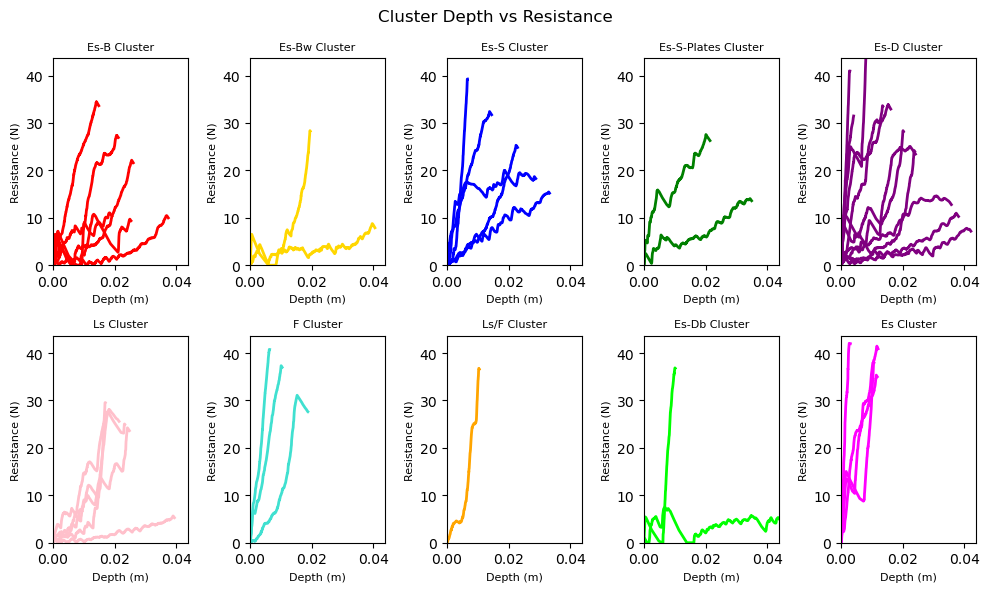

In [421]:
marions_labeled_data[f'{ylabel_name}_nums'] = marions_labeled_data[ylabel_name].map(ylabel_to_cluster_num)
plotting.plot_clusters_seperately(marions_labeled_data[f'{ylabel_name}_nums'], curve_data, ylabel_name,
                                  cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  bold_idxs=marions_labeled_data.index.tolist()) 
plotting.plot_pca(marions_labeled_data, marions_labeled_data[f'{ylabel_name}_nums'], graph_title="Clustering Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)

# Plot Corrected Labeling

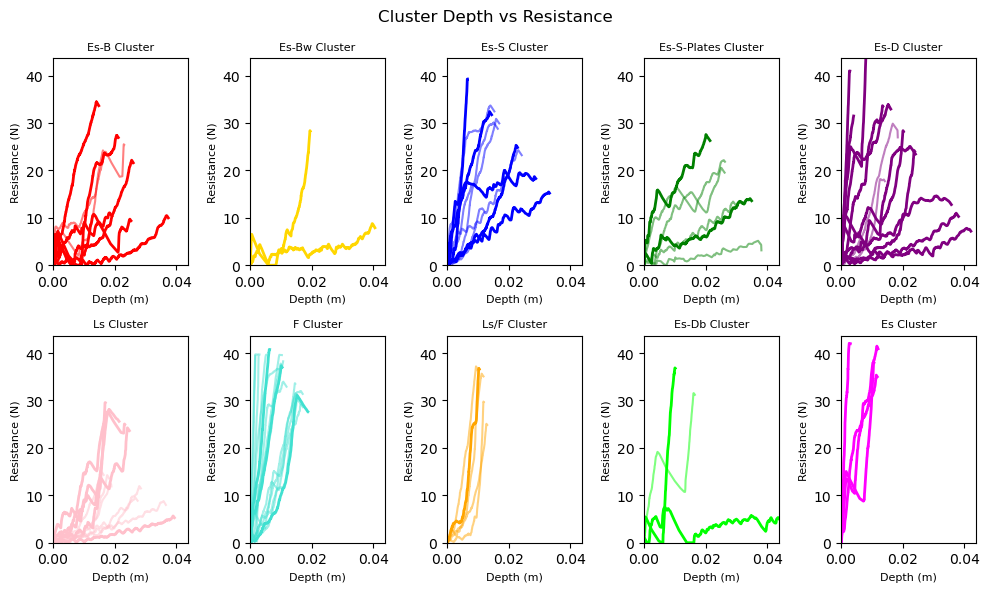

In [422]:
def correct_pseudo_ylabels_to_actual(pseudo_labeled_data:pd.DataFrame, actual_labeled_data:pd.DataFrame, ylabel_name, changed_ylabel_idxs):
    corrected_pseudo_labeled_data = pseudo_labeled_data.copy()
    corrected_pseudo_labeled_data.loc[changed_ylabel_idxs, f'pseudo_{ylabel_name}'] = actual_labeled_data[ylabel_name]
    corrected_pseudo_labeled_data.loc[changed_ylabel_idxs, f'pseudo_{ylabel_name}_nums'] = actual_labeled_data[f'{ylabel_name}_nums']
    return corrected_pseudo_labeled_data

corrected_pseudo_labeled_data = correct_pseudo_ylabels_to_actual(pseudo_labeled_data, marions_labeled_data, ylabel_name, changed_ylabel_idxs)


plotting.plot_clusters_seperately(corrected_pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], 
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), 
                                  pseudo_corrections=marions_labeled_data)
plotting.plot_pca(corrected_pseudo_labeled_data, corrected_pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], graph_title="Clustering Corrected Pseudo Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)


# Plot Un-corrected Labeling

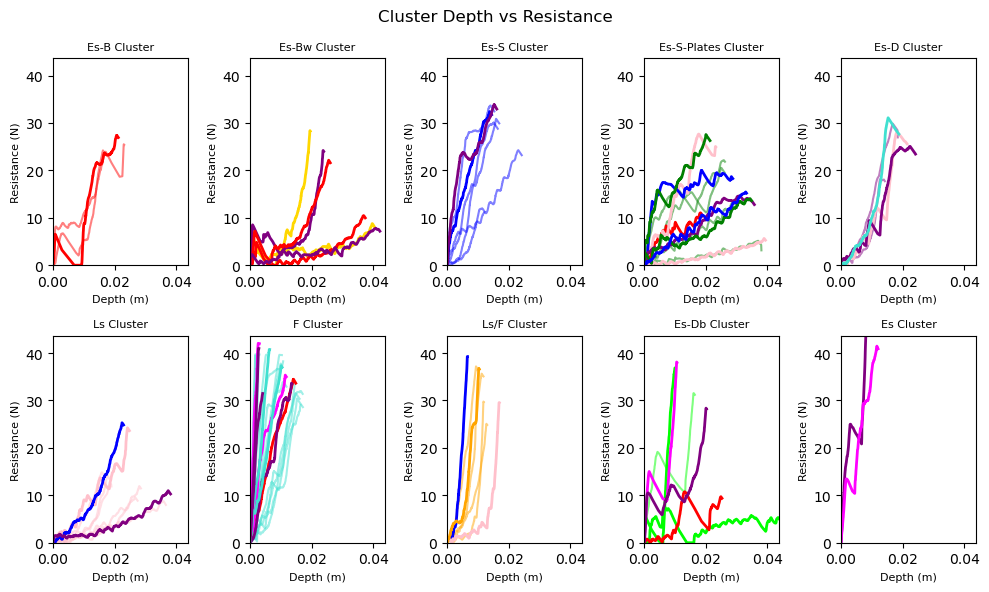

In [423]:
plotting.plot_clusters_seperately(pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'],
                                  curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()),
                                  pseudo_corrections=marions_labeled_data)
plotting.plot_pca(pseudo_labeled_data, pseudo_labeled_data[f'pseudo_{ylabel_name}_nums'], graph_title="Clustering Un-corrected Pseudo Labeled Data", num_pc=3, ylabel_name=ylabel_name, centroids=label_centroids)

# Clustering data with ES-D removed (Corrected)

Labeled data only


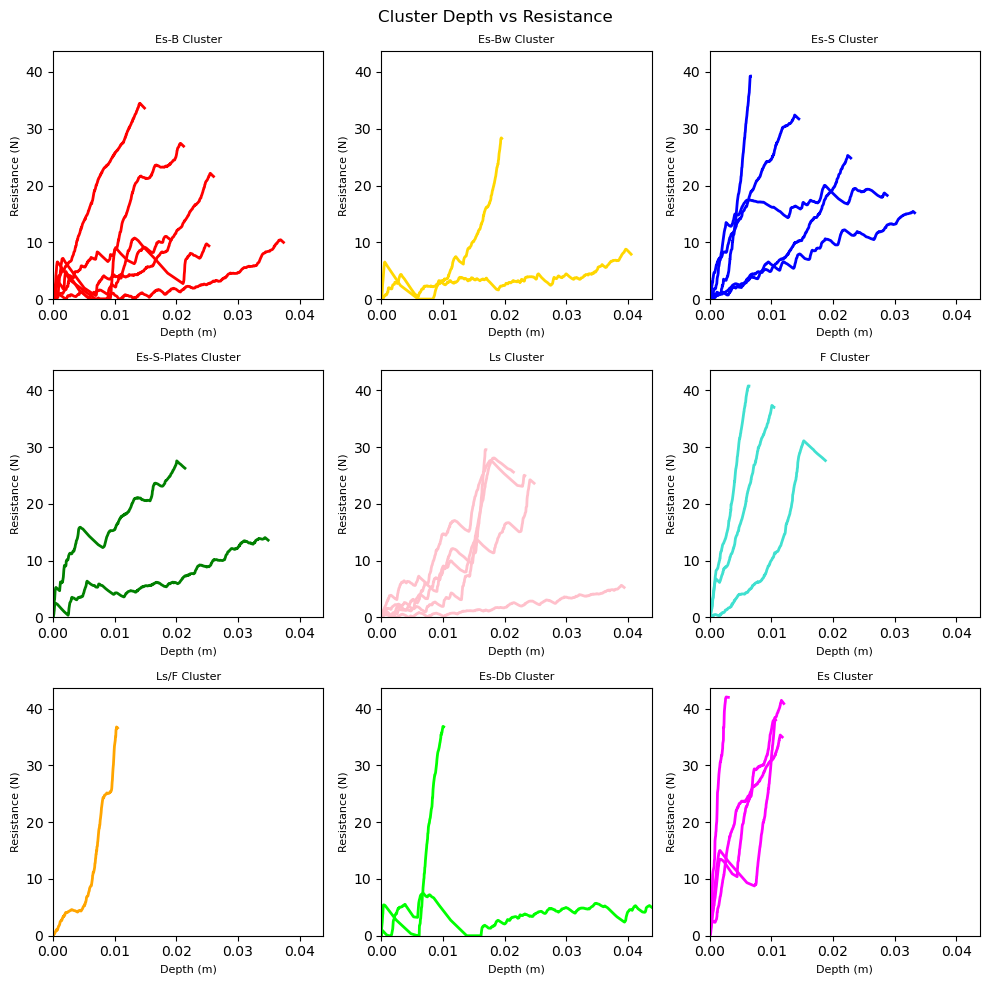

Uncorrected


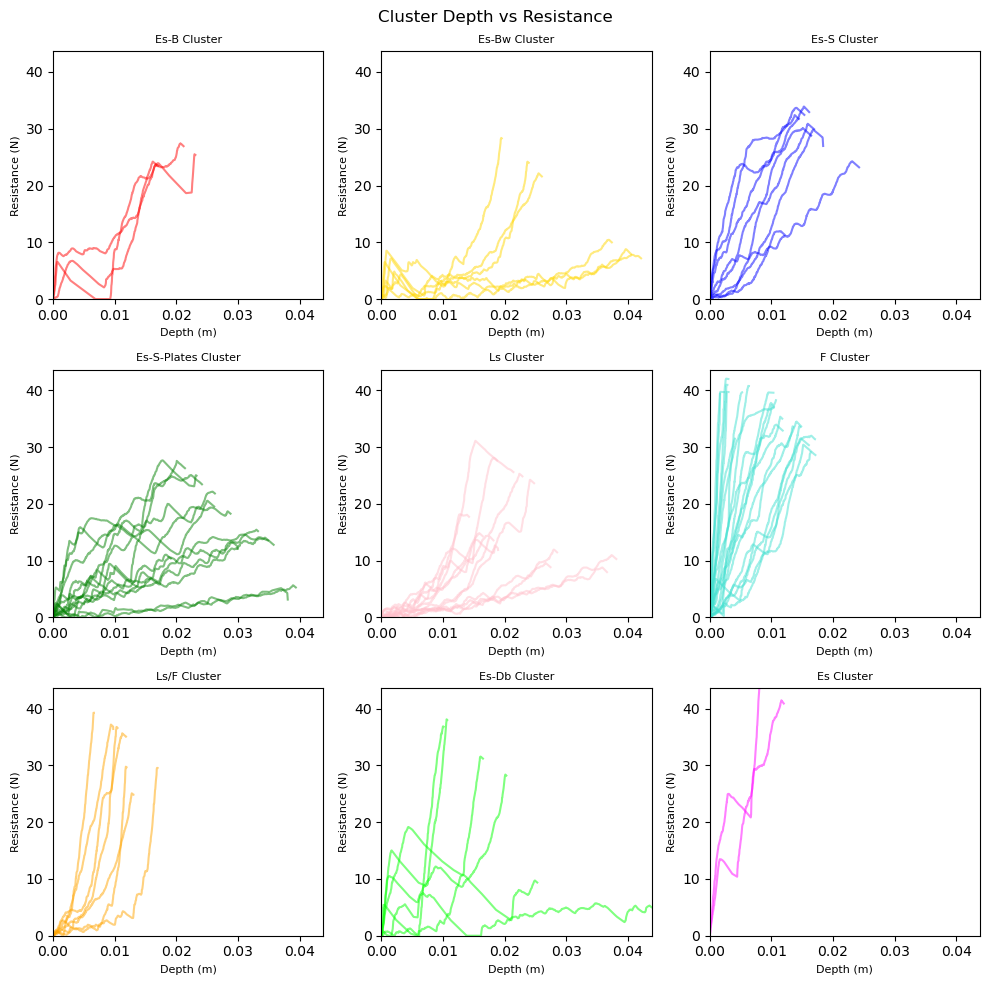

Corrected


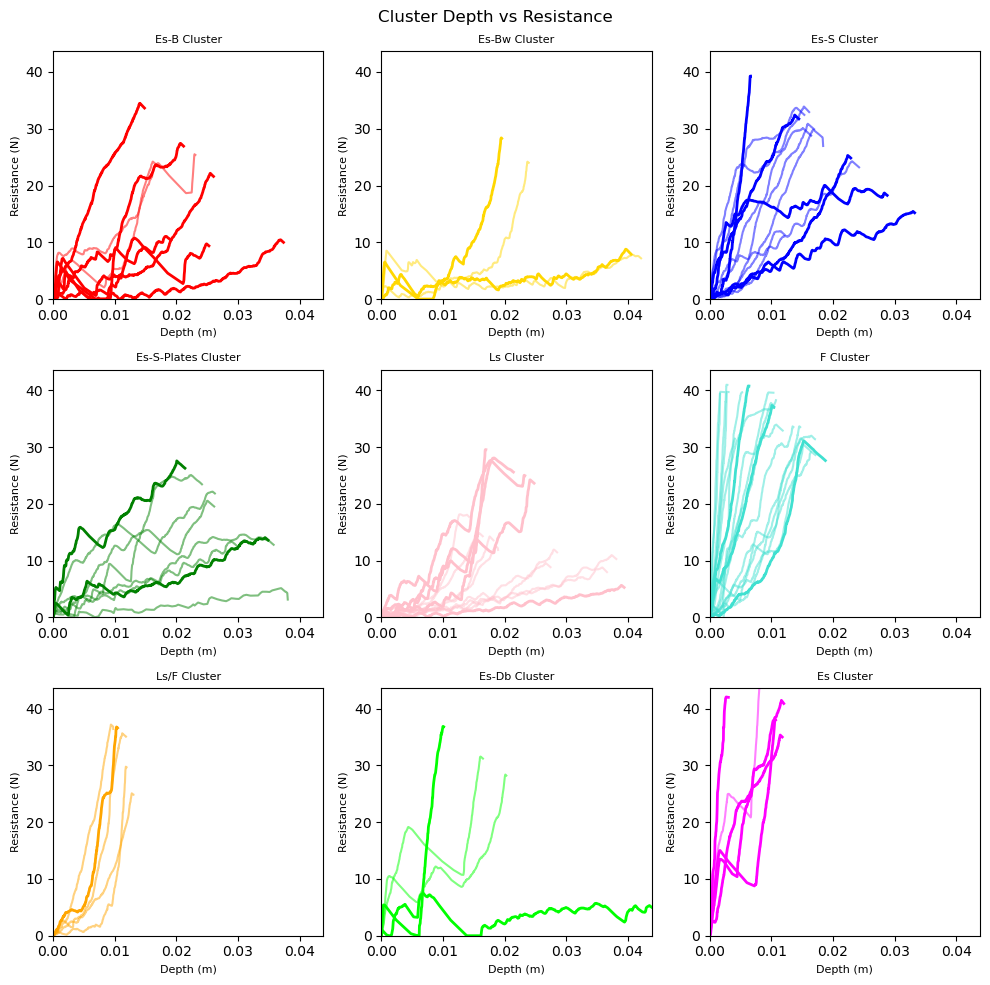

In [424]:
# should labels be fixed or not
removed_dark_labeled_data = marions_labeled_data[marions_labeled_data[ylabel_name] != 'ES-D'].copy()
print('Labeled data only')
plotting.plot_clusters_seperately(removed_dark_labeled_data[f'{ylabel_name}_nums'], curve_data, ylabel_name, bold_idxs=removed_dark_labeled_data.index.tolist(), cluster_category_names=list(ylabel_to_cluster_num.keys()))

# print('ES-D' in removed_dark_labeled_data['marions_ylabels_2'].values)
removed_dark_label_centroids = find_labels_centroids(removed_dark_labeled_data, ylabel_to_cluster_num, ylabel_name)
removed_dark_pseudo_data = find_closest_centroid(data_features, removed_dark_label_centroids, ylabel_name)

print('Uncorrected')
plotting.plot_clusters_seperately(removed_dark_pseudo_data[f'pseudo_{ylabel_name}_nums'], curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()))
# print(removed_dark_label_centroids)
plotting.plot_pca(removed_dark_pseudo_data, removed_dark_pseudo_data[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=removed_dark_label_centroids)

print('Corrected')
# print(print('ES-D' in removed_dark_pseudo_data['pseudo_marions_ylabels_2'].values))
changed_ylabel_idxs = find_changed_ylabel_data(removed_dark_labeled_data, removed_dark_pseudo_data, ylabel_name)
corrected_removed_dark_pseudo_data = correct_pseudo_ylabels_to_actual(removed_dark_pseudo_data, marions_labeled_data, ylabel_name, changed_ylabel_idxs)
# print(corrected_removed_dark_pseudo_data)
plotting.plot_clusters_seperately(corrected_removed_dark_pseudo_data[f'pseudo_{ylabel_name}_nums'], curve_data, ylabel_name, cluster_category_names=list(ylabel_to_cluster_num.keys()), pseudo_corrections=removed_dark_labeled_data)
# print(removed_dark_label_centroids)
plotting.plot_pca(corrected_removed_dark_pseudo_data, corrected_removed_dark_pseudo_data[f'pseudo_{ylabel_name}_nums'], 3, graph_title="", ylabel_name=ylabel_name, centroids=removed_dark_label_centroids)